In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
import IMNN.IMNN as IMNN
import IMNN.ABC.ABC as ABC
%matplotlib inline

In [3]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pickle.load(open('simulators/cosmic_shear/pz_5bin.pkl', 'rb')), 
                                                           lmin = 10, lmax = 1000, n_ell_bins = 5, sigma_e = 0.3, 
                                                           nbar = 30, Area = 15000)

def simulator(theta, seed, simulator_args):
    simulation = CosmicShearSimulator.simulate(theta, seed)
    nmodes = simulation.shape[0]
    nz = simulation.shape[1]
    d = np.zeros((int(nmodes*nz*(nz+1)/2)))
    for i in range(nmodes):
        x = np.tril(simulation[:, :, i])
        d[i*int(nz*(nz+1)/2):(i+1)*int(nz*(nz+1)/2)] = x[x != 0]
    return d

def derivative_simulator(theta, seed, h, derivative_args):
    simulation = CosmicShearSimulator.compute_derivatives(theta, h)
    params = simulation.shape[0]
    nmodes = simulation.shape[1]
    nz = simulation.shape[2]
    d = np.zeros((params, int(nmodes*nz*(nz+1)/2)))
    for j in range(params):
        for i in range(nmodes):
            x = np.tril(simulation[j, :, :, i])
            d[j, i*int(nz*(nz+1)/2):(i+1)*int(nz*(nz+1)/2)] = x[x != 0]
    return d
    
simulator_args = None
derivative_args = None

In [4]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [6]:
### SET UP THE COMPRESSOR ###

input_shape = [CosmicShearSimulator.nz*CosmicShearSimulator.n_ell_bins*(CosmicShearSimulator.n_ell_bins+1)//2]

# Fiducial parameters
θ_fid = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Δθpm = θ_fid*0.05

n_s = 10
num_sims = n_s
n_p = 1
seed = np.random.randint(1e6)

t = np.array([simulator(θ_fid, np.random.randint(1e6), simulator_args) for i in range(num_sims)])
t_d = np.array([derivative_simulator(θ_fid, seed, Δθpm, derivative_args)])
tt = np.array([simulator(θ_fid, np.random.randint(1e6), simulator_args) for i in range(num_sims)])
tt_d = t_d

IMNN_data = {"data": t, "data_d": t_d, "validation_data": tt, "validation_data_d": tt_d}

parameters = {
    "dtype": 32,
    "number of simulations": n_s,
    "number of derivative simulations": n_p,
    "fiducial": θ_fid.tolist(),
    "number of summaries": 5,
    "input shape": input_shape,
    "filename": "data/model",
}

tf.reset_default_graph()
n = IMNN.IMNN(parameters = parameters)

def build_network(data, **kwargs):
    α = kwargs["activation_parameter"]
    input_shape = kwargs["input_shape"]
    with tf.variable_scope("layer_1"):
        weights = tf.get_variable("weights", shape = [input_shape[-1], 128], initializer = tf.variance_scaling_initializer())
        output = tf.nn.leaky_relu(tf.matmul(data, weights, name = "multiply"), name = "output")
    with tf.variable_scope("layer_2"):
        weights = tf.get_variable("weights", shape = (128, 128), initializer = tf.variance_scaling_initializer())
        output = tf.nn.leaky_relu(tf.matmul(output, weights, name = "multiply"), name = "output")
    with tf.variable_scope("layer_3"):
        weights = tf.get_variable("weights", shape = (128, 128), initializer = tf.variance_scaling_initializer())
        output = tf.nn.leaky_relu(tf.matmul(output, weights, name = "multiply"), name = "output")
    with tf.variable_scope("layer_4"):
        weights = tf.get_variable("weights", shape = (128, n.n_summaries), initializer = tf.variance_scaling_initializer())
        output = tf.matmul(output, weights, name = "output")
    return output

α = tf.placeholder(dtype = tf.float32, shape = (), name = "activation_parameter")
network = lambda x: build_network(x, activation_parameter = α, input_shape = input_shape)
graph_dictionary = {"activation_parameter:0": 0.001}

n.setup(network = network, load_data = IMNN_data)

saving the graph as data/model.meta


In [ ]:
updates = 10000
at_once = 1000
learning_rate = 1e-4

n.train(updates, at_once, learning_rate, constraint_strength = 2.,
        training_dictionary = graph_dictionary,
        validation_dictionary = graph_dictionary,
        get_history = True, restart = False, diagnostics = False)

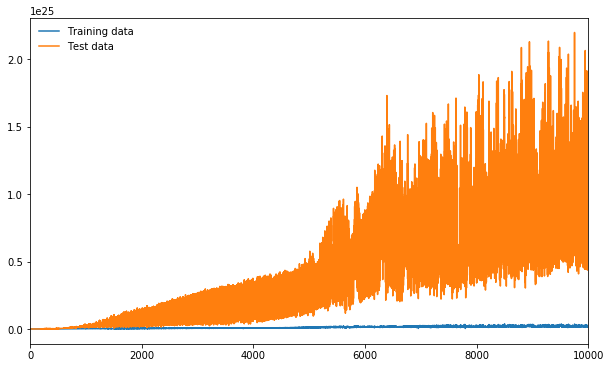

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, figsize = (10, 6))
epochs = np.arange(1, len(n.history["det F"]) + 1)
ax.plot(epochs, n.history["det F"], label = 'Training data')
ax.plot(epochs, n.history["det test F"], label = 'Test data')
ax.legend(frameon = False)
ax.set_xlim([1, epochs[-1]]);

In [ ]:
# Simulator in DELFI format
def delfi_simulator(theta, seed, simulator_args, batch):
    simulation = CosmicShearSimulator.simulate(theta, seed)
    nmodes = simulation.shape[0]
    nz = simulation.shape[1]
    d = np.zeros((int(nmodes*nz*(nz+1)/2)))
    for i in range(nmodes):
        x = np.tril(simulation[:, :, i])
        d[i*int(nz*(nz+1)/2):(i+1)*int(nz*(nz+1)/2)] = x[x != 0]
    return d
simulator_args = None

# Compress to IMNN summaries
def delfi_compressor(data, compressor_args):
    return n.sess.run("MLE:0", feed_dict = {**graph_dictionary, **{"data:0": np.atleast_2d(data)}})[0,:]
compressor_args = None

# Compressed data
real_data = delfi_simulator(θ_fid, 0, simulator_args, 1)
compressed_data = delfi_compressor(real_data, compressor_args)

# Inverse Fisher matrix from IMNN
abc = ABC.ABC(real_data = np.array([real_data]), prior = prior, sess = n.sess, get_compressor = n.get_compressor, simulator = simulator, seed = None, simulator_args = {"input shape": input_shape}, dictionary = graph_dictionary)
F = abc.fisher
Finv = np.linalg.inv(F)

In [ ]:
# Create an ensemble of NDEs (here, Mixture Density Networks)
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

# Create the DELFI object
DelfiMDN = delfi.Delfi(compressed_data, prior, NDEs, Finv=Finv, theta_fiducial=θ_fid, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/imnn_mdn",
                       input_normalization='fisher')

In [ ]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model
Sampling approximate posterior...
Done.
Removed no burn in


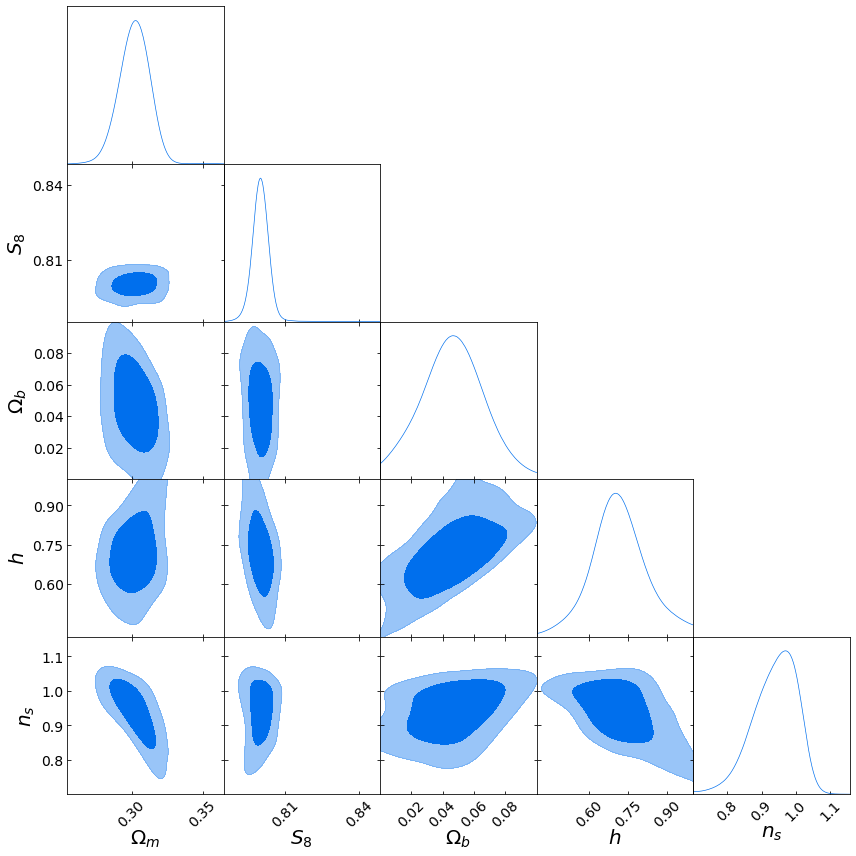

Population 1/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


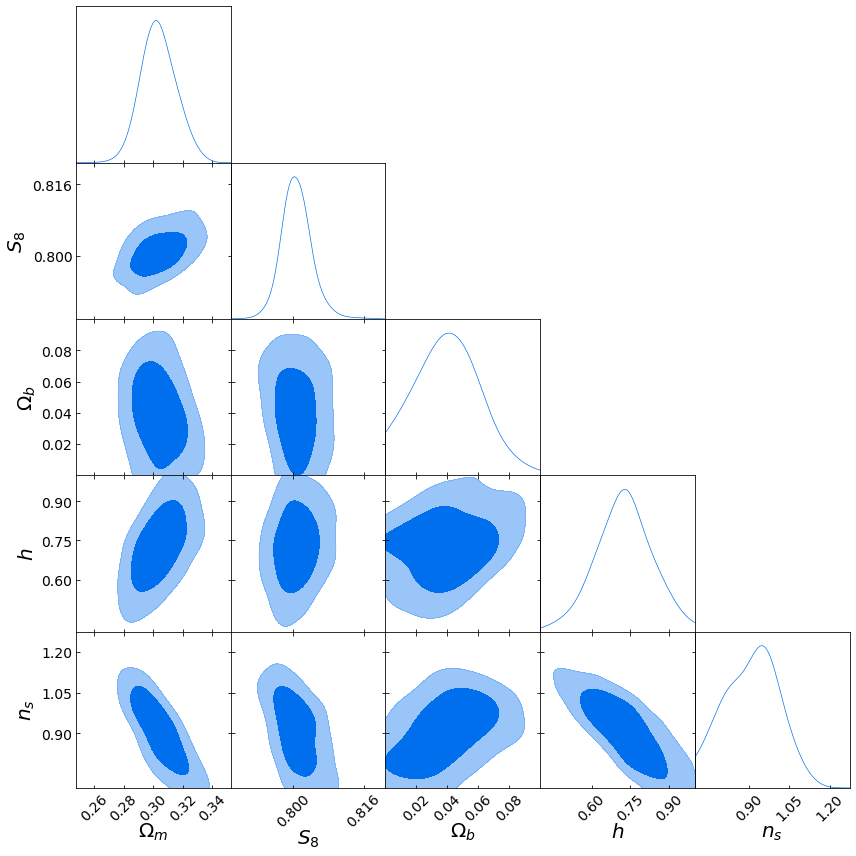

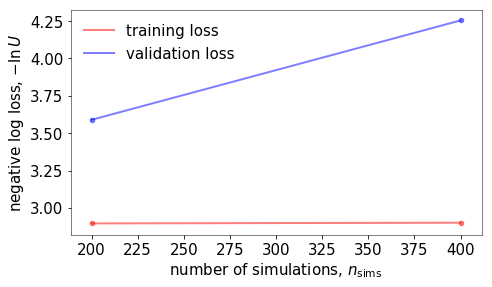

Population 2/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


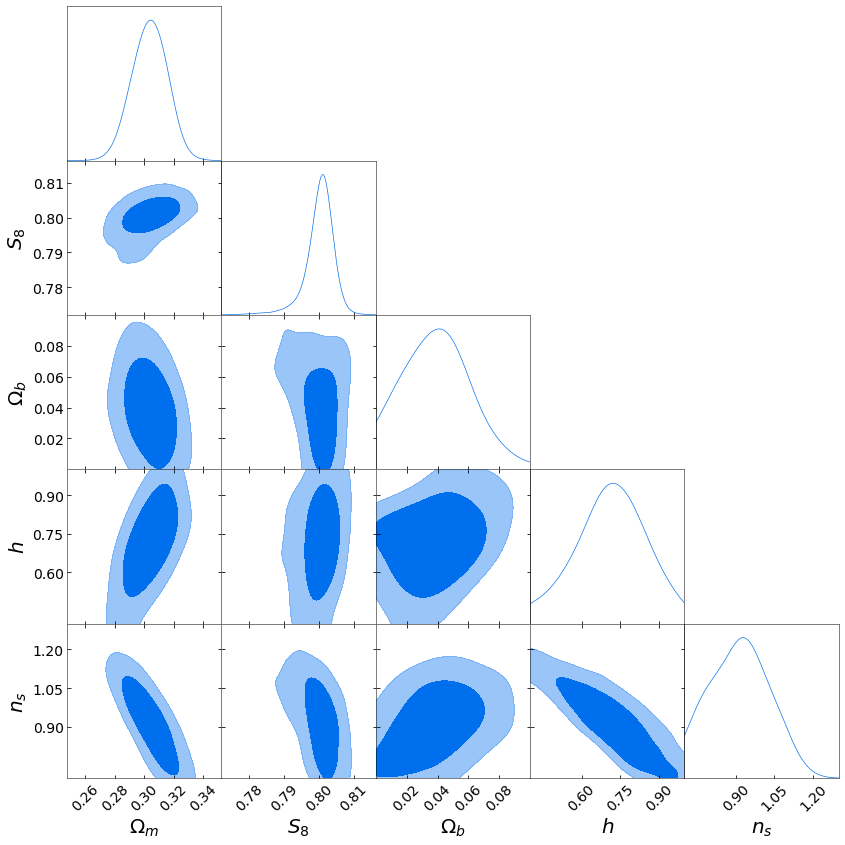

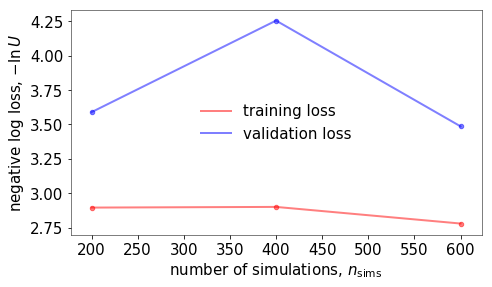

Population 3/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


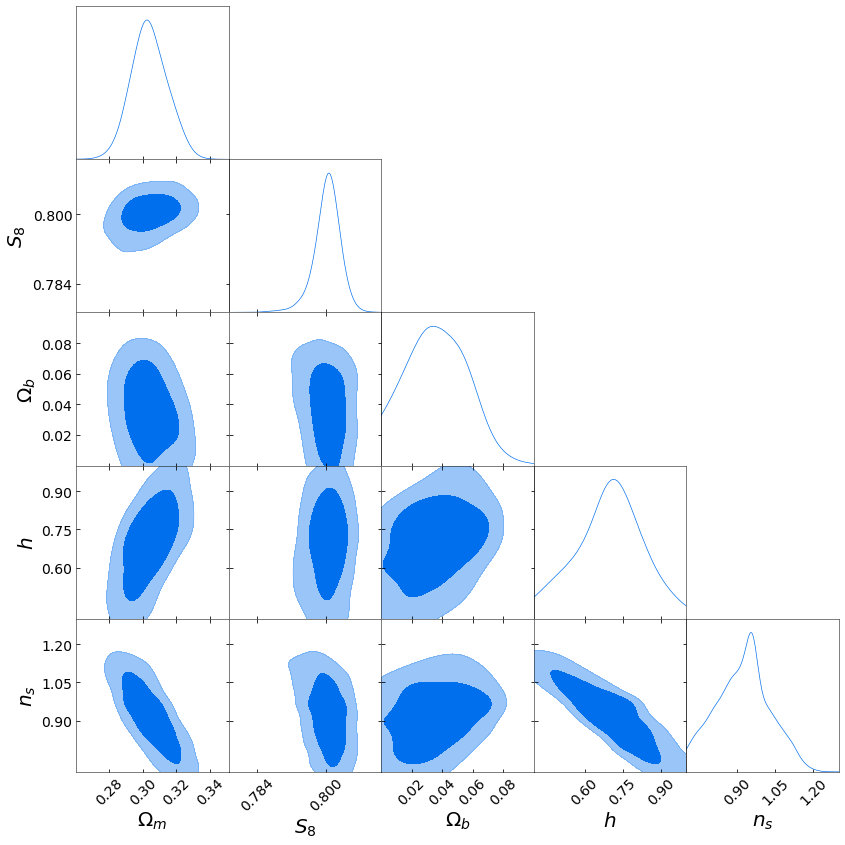

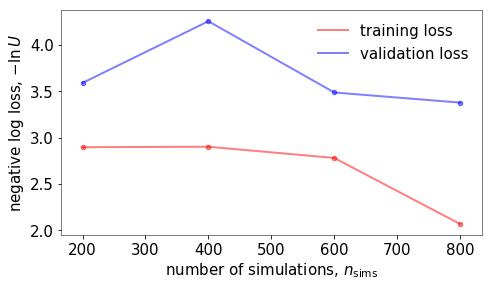

Population 4/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


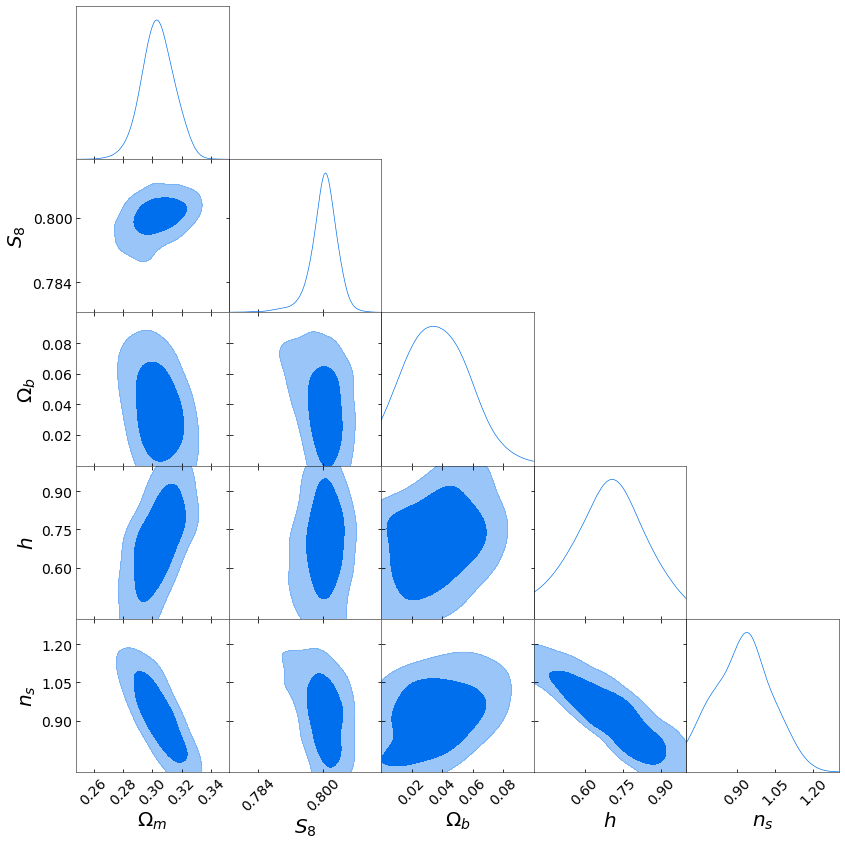

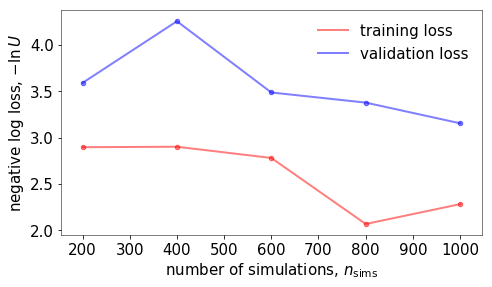

Population 5/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


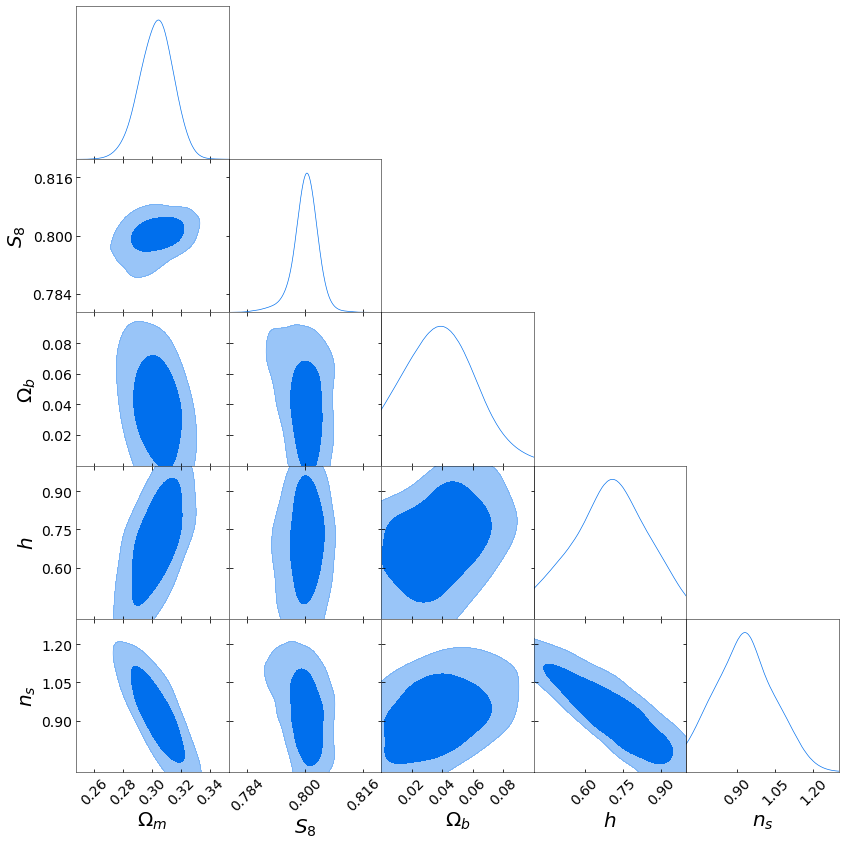

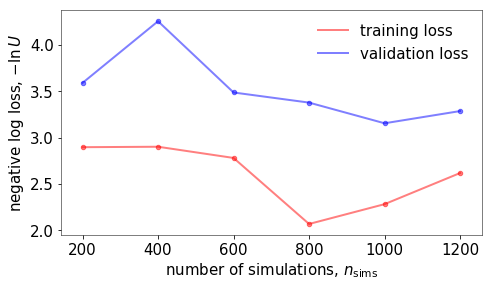

Population 6/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


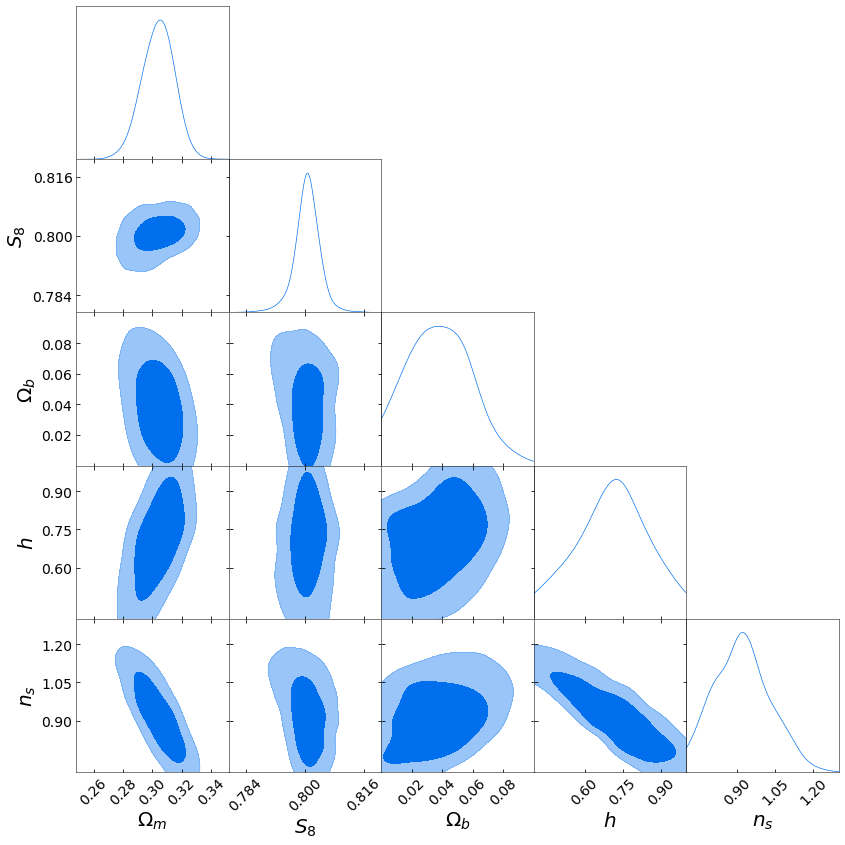

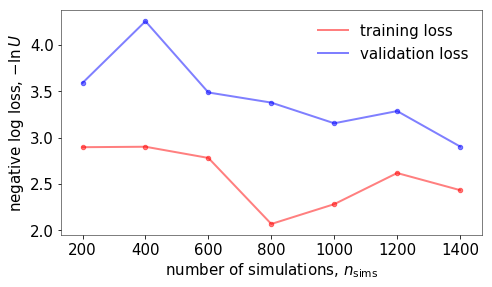

Population 7/39
Sampling proposal density...
Done.


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 39

# Do the SNL training
DelfiMDN.sequential_training(delfi_simulator, delfi_compressor, n_initial, n_batch, n_populations, patience=20, save_intermediate_posteriors=True)

In [ ]:
plt.close()
columnwidth = 18 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 15,
                 'legend.fontsize': 15,
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})

# Trace plot of the training and validation loss as a function of the number of simulations ran
plt.scatter(DelfiNDE.sequential_nsims, DelfiNDE.sequential_training_loss, s = 20, alpha = 0.5)
plt.plot(DelfiNDE.sequential_nsims, DelfiNDE.sequential_training_loss, color = 'red', lw = 2, alpha = 0.5, label = 'training loss')
plt.scatter(DelfiNDE.sequential_nsims, DelfiNDE.sequential_validation_loss, s = 20, alpha = 0.5)
plt.plot(DelfiNDE.sequential_nsims, DelfiNDE.sequential_validation_loss, color = 'blue', lw = 2, alpha = 0.5, label = 'validation loss')

#plt.fill_between(DelfiMAF.sequential_nsims, (DelfiMAF.sequential_validation_loss[-1]-0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), 
#                 (DelfiMAF.sequential_validation_loss[-1]+0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), color = 'grey', alpha = 0.2 )

plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log loss, $-\mathrm{ln}\,U$')
#plt.savefig('../../paper_II/plots/convergence_fixedII.pdf')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
emcee_samples = np.loadtxt("emcee_samples.dat")
posterior_samples = np.loadtxt("posterior_samples.dat")
#DelfiNDE.triangle_plot([emcee_samples, posterior_samples, DelfiNDE.posterior_samples])
DelfiNDE.triangle_plot([emcee_samples, posterior_samples])